In [ ]:
%pip install keras-tuner
%pip install keras_self_attention

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-e2c1cb2b-8d9e-a9ff-2873-22799dff824b)


In [ ]:
import tensorflow as tf
import site
import pandas as pd
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Concatenate, BatchNormalization, GaussianNoise
from tensorflow.keras.layers import LSTM, TimeDistributed, Permute, Reshape, Lambda, RepeatVector, Input, Multiply, SimpleRNN, GRU, LeakyReLU
import os
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 40)


In [ ]:
tf.__version__

'2.6.0'

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import h5py as h5
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import errno
import os
from collections import defaultdict
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.summary import create_file_writer
from sklearn.model_selection import train_test_split
import numpy as np
import itertools
import multiprocessing

In [ ]:
def coShuffled_vectors(X, Y):
    if tf.shape(X)[0] == tf.shape(Y)[0]:
        test_idxs = tf.range(start=0, limit=tf.shape(X)[0], dtype=tf.int32)
        shuffled_test_idxs = tf.random.shuffle(test_idxs)
        return (tf.gather(X, shuffled_test_idxs), tf.gather(Y, shuffled_test_idxs))
    else:
        raise ValueError(f"0-dimension has to be the same {tf.shape(X)[0]} != {tf.shape(Y)[0]}")


def getNpArrayFromH5(hf_Data):
    X_train = hf_Data['Train_Data']  # Get train set
    X_train = np.array(X_train)
    Y_train = hf_Data['Label']  # Get train label
    Y_train = np.array(Y_train)
    return X_train, Y_train

# data extraction
def getData(is500=True, shuffle=False, ise2e=False, include_secondary=False, validation_split=None, isColab=False):
    if not include_secondary:
        hf_Train = h5.File(
            f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/{"e2e_Train_Data" if ise2e else "Fold_10_Train_Data"}_{str(500) if is500 else str(1000)}.h5', 'r')
        hf_Test = h5.File(
            f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/{"e2e_Test_Data" if ise2e else "Fold_10_Test_Data"}_{str(500) if is500 else str(1000)}.h5', 'r')
    else:
        hf_Train = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Train_Secondary_Data_1136.h5', 'r')
        hf_Test = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Test_Secondary_Data_1136.h5', 'r')

    X_train, Y_train = getNpArrayFromH5(hf_Train)
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    Y_train = to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = to_categorical(Y_test, 13)  # Process the label of te

    if shuffle:
        X_train, Y_train = coShuffled_vectors(X_train, Y_train)
        X_test, Y_test = coShuffled_vectors(X_test, Y_test)

    X_validation = Y_validation = None
    if validation_split is not None:
        # sklearn split shuffles anyway
        X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=validation_split)

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation


def getE2eData(is500=True, shuffle=False, include_secondary=False, isColab=False):
    if not include_secondary:
        hf_Train = h5.File(
            f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Train_Data_{str(500) if is500 else str(1000)}.h5', 'r')
        hf_Test = h5.File(
            f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Test_Data_{str(500) if is500 else str(1000)}.h5', 'r')
    else:
        hf_Train = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Train_Secondary_Data_1136.h5', 'r')
        hf_Test = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Test_Secondary_Data_1136.h5', 'r')

    X_train, Y_train = getNpArrayFromH5(hf_Train)
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    Y_train = to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = to_categorical(Y_test, 13)  # Process the label of te

    if shuffle:
        X_train, Y_train = coShuffled_vectors(X_train, Y_train)
        X_test, Y_test = coShuffled_vectors(X_test, Y_test)

    hf_Val = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Val_Secondary_Data_1136.h5', 'r') if include_secondary else h5.File(
        f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Val_Data_{str(500) if is500 else str(1000)}.h5', 'r')
    X_validation, Y_validation = getNpArrayFromH5(hf_Val)
    Y_validation = to_categorical(Y_validation, 13)  # Process the label of tain

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation


def getE2eDataJustSecondary(shuffle=False,isColab=False):
    hf_Train = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Train_just_Secondary_Data_1000.h5', 'r')
    hf_Test = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Test_just_Secondary_Data_1000.h5', 'r')

    X_train, Y_train = getNpArrayFromH5(hf_Train)
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    Y_train = to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = to_categorical(Y_test, 13)  # Process the label of te

    if shuffle:
        X_train, Y_train = coShuffled_vectors(X_train, Y_train)
        X_test, Y_test = coShuffled_vectors(X_test, Y_test)

    hf_Val = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Val_just_Secondary_Data_1000.h5', 'r')
    
    X_validation, Y_validation = getNpArrayFromH5(hf_Val)
    Y_validation = to_categorical(Y_validation, 13)  # Process the label of tain

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation


In [ ]:
def plot_history(history):
    acc_keys = [k for k in history.history.keys() if k in ('accuracy', 'val_accuracy')]
    loss_keys = [k for k in history.history.keys() if not k in acc_keys]
    for k, v in history.history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        else:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()


def get_layer_by_name(layers, name, return_first=True):
    matching_named_layers = [l for l in layers if l.name == name]
    if not matching_named_layers:
        return None
    return matching_named_layers[0] if return_first else matching_named_layers


def get_combined_features_from_models(
        to_combine,
        X_train, Y_train,
        X_test, Y_test,
        reverse_one_hot=False,
        normalize_X_func=None):
    models = []
    models_dict = {}
    X_trains_out = []
    X_test_out = []
    XY_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: None))))

    if reverse_one_hot:
        Y_train_new = np.apply_along_axis(np.argmax, 1, Y_train) + 1
        Y_test_new = np.apply_along_axis(np.argmax, 1, Y_test) + 1
    else:
        Y_train_new = Y_train.copy()
        Y_test_new = Y_test.copy()

    for model_file_name, layer_name, kwargs in to_combine:
        model_here = None
        if isinstance(model_file_name, tf.keras.models.Model):
            model_here = model_file_name
            model_file_name = model_here.name
        else:
            if model_file_name in models_dict.keys():
                model_here = models_dict[model_file_name]
            else:
                model_here = tf.keras.models.load_model(model_file_name,
                                                        **kwargs) if kwargs is not None else tf.keras.models.load_model \
                    (model_file_name)

        features_model = Model(model_here.input,
                               get_layer_by_name(model_here.layers, layer_name).output)
        if normalize_X_func is None:
            X_trains_out.append(np.array(features_model.predict(X_train), dtype='float64'))
            X_test_out.append(np.array(features_model.predict(X_test), dtype='float64'))
        else:
            X_trains_out.append(np.array(normalize_X_func(features_model.predict(X_train)), dtype='float64'))
            X_test_out.append(np.array(normalize_X_func(features_model.predict(X_test)), dtype='float64'))
        XY_dict[model_file_name][layer_name]['Train']['X'] = X_trains_out[-1]
        XY_dict[model_file_name][layer_name]['Test']['X'] = X_test_out[-1]
        XY_dict[model_file_name][layer_name]['Train']['Y'] = Y_train_new
        XY_dict[model_file_name][layer_name]['Test']['Y'] = Y_test_new
        models.append(((model_file_name, layer_name), (model_here, features_model)))
        models_dict[model_file_name] = model_here

    X_train_new = np.concatenate(tuple(X_trains_out), axis=1)
    X_test_new = np.concatenate(tuple(X_test_out), axis=1)

    data_train = (X_train_new, Y_train_new)
    data_test = (X_test_new, Y_test_new)

    return models, data_train, data_test, XY_dict


def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')


def source_model(model_func, model_name, input_shape):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
    return m


def compile_and_fit_model_with_tb(model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_every_epoch=True,
                                  save_final=False,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
    tb_callback = TensorBoard(log_dir=f'{m.name}_logs', histogram_freq=kwargs.pop("histogram_freq", 1))
    if save_every_epoch:
        tb_callback.append(ModelCheckpoint(f'{m.name}' + '_model_{epoch:03d}_{val_accuracy:0.2f}'))
    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = m.fit(X_train, Y_train, callbacks=[tb_callback], verbose=2, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)
    # m.save(f"{m.name}_Tenth_Fold_New_Model_500_8") #Save the model


def compile_and_fit_model(model_func,
                          model_name,
                          input_shape,
                          X_train,
                          Y_train,
                          save_every_epoch=True,
                          save_final=False,
                          **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)

    callbacks_used = []
    if save_every_epoch:
        callbacks_used.append(ModelCheckpoint(f'{m.name}' + '_model_{epoch:03d}_{val_accuracy:0.2f}'))
    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = m.fit(X_train, Y_train, callbacks=callbacks_used, verbose=2, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)


def compile_model_and_fit_with_custom_loop(model_func,
                                           model_name,
                                           input_shape,
                                           X_train,
                                           Y_train,
                                           **kwargs):
    make_dir_if_not_exist(model_name)
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)

    train_writer = create_file_writer(f'{m.name}_logs/train/')
    test_writer = create_file_writer(f'{m.name}_logs/test/')
    train_step = test_step = 0

    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    optimizer = tf.keras.optimizers.Adam()
    num_epochs = kwargs.get("epochs", 10)

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    BATCH_SIZE = kwargs.get("batch_size", 32)
    X_test, Y_test = kwargs.get("validation_data", (None, None))
    if X_test is None:
        raise ValueError("Missing X validation data")
    if Y_test is None:
        raise ValueError("Missing Y validation data")

    train_dataset_tf = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    train_dataset_tf = train_dataset_tf.batch(BATCH_SIZE)
    train_dataset_tf = train_dataset_tf.prefetch(AUTOTUNE)

    test_dataset_tf = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    test_dataset_tf = train_dataset_tf.batch(BATCH_SIZE)
    test_dataset_tf = train_dataset_tf.prefetch(AUTOTUNE)

    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    for epoch in range(num_epochs):
        # Iterate through training set
        for batch_idx, (x, y) in enumerate(train_dataset_tf):
            with tf.GradientTape() as tape:
                y_pred = m(x, training=True)
                loss = loss_fn(y, y_pred)

            gradients = tape.gradient(loss, m.trainable_weights)
            optimizer.apply_gradients(zip(gradients, m.trainable_weights))
            acc_metric.update_state(y, y_pred)

            with train_writer.as_default():
                tf.summary.scalar("Loss", loss, step=train_step)
                tf.summary.scalar(
                    "Accuracy", acc_metric.result(), step=train_step,
                )
                train_step += 1
        # Reset accuracy in between epochs (and for testing and test)
        acc_metric.reset_states()
        # Iterate through test set
        for batch_idx, (x, y) in enumerate(test_dataset_tf):
            y_pred = m(x, training=False)
            loss = loss_fn(y, y_pred)
            acc_metric.update_state(y, y_pred)
            with test_writer.as_default():
                tf.summary.scalar("Loss", loss, step=test_step)
                tf.summary.scalar(
                    "Accuracy", acc_metric.result(), step=test_step,
                )
                test_step += 1

        acc_metric.reset_states()  # Reset accuracy in between epochs (and for testing and test)

    return m


def reinitialize_weights(model):
    for ix, layer in enumerate(model.layers):
        if hasattr(model.layers[ix], 'kernel_initializer') and hasattr(model.layers[ix], 'bias_initializer'):
            weight_initializer = model.layers[ix].kernel_initializer
            bias_initializer = model.layers[ix].bias_initializer

            old_weights, old_biases = model.layers[ix].get_weights()

            model.layers[ix].set_weights([
                weight_initializer(shape=old_weights.shape),
                bias_initializer(shape=len(old_biases))])
    return model


def reverse_tensor(X):
    return tf.gather(X, tf.reverse(tf.range(start=0, limit=tf.shape(X)[0], dtype=tf.int32), (0,)))


def run_mirrored_strategy(model_func, base_batch_size, nepochs, x_train, y_train, x_test, y_test, **kwargs):
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        model = model_func()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=tf.keras.metrics.SparseCategoricalAccuracy()
        )
    batch_size_mirr_strat = base_batch_size * strategy.num_replicas_in_sync
    history = model.fit(x_train, y_train, epochs=nepochs, batch_size=batch_size_mirr_strat,
                        validation_data=(x_test, y_test),
                        **kwargs)
    return model, history


def sparse_setdiff(a1, a2):
    a1a = a1.reshape(a1.shape[0], -1)
    a2a = a2.reshape(a2.shape[0], -1)
    spa2a = [np.where(x)[0].tolist() for x in a2a]
    spa1a = [np.where(x)[0].tolist() for x in a1a]
    idxs_to_keep = []
    for idx, sample in enumerate(spa1a):
        try:
            spa2a.index(sample)
        except ValueError:
            # not in list
            idxs_to_keep.append(idx)
    return a1[idxs_to_keep], idxs_to_keep


def unpacking_apply_along_axis(all_args):
    """
    Like numpy.apply_along_axis(), but with arguments in a tuple
    instead.

    This function is useful with multiprocessing.Pool().map(): (1)
    map() only handles functions that take a single argument, and (2)
    this function can generally be imported from a module, as required
    by map().
    """
    (func1d, axis, arr, args, kwargs) = all_args
    # return np.apply_along_axis(func1d, axis, arr, *args, **kwargs)


def parallel_apply_along_axis(func1d, axis, arr, *args, **kwargs):
    """
    Like numpy.apply_along_axis(), but takes advantage of multiple
    cores.
    """
    # Effective axis where apply_along_axis() will be applied by each
    # worker (any non-zero axis number would work, so as to allow the use
    # of `np.array_split()`, which is only done on axis 0):
    effective_axis = 1 if axis == 0 else axis
    if effective_axis != axis:
        arr = arr.swapaxes(axis, effective_axis)

    # Chunks for the mapping (only a few chunks):
    chunks = [(func1d, effective_axis, sub_arr, args, kwargs)
              for sub_arr in np.array_split(arr, multiprocessing.cpu_count())]

    pool = multiprocessing.Pool()
    individual_results = pool.map(unpacking_apply_along_axis, chunks)
    # Freeing the workers:
    pool.close()
    pool.join()

    return np.concatenate(individual_results)


In [ ]:
def model_A_CNN_256(model_name, inshape, num_classes = 13):

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same' ,input_shape=inshape))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(2))

    model.add(tf.keras.layers.GaussianNoise(1))
    model.add(tf.keras.layers.Dropout(rate=0.5))

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(4))

    model.add(tf.keras.layers.GaussianNoise(1))
    model.add(tf.keras.layers.Dropout(rate=0.5))

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(2))

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(4))

    model.add(tf.keras.layers.GaussianNoise(1))
    model.add(tf.keras.layers.Dropout(rate=0.5))

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(4))

    model.add(tf.keras.layers.GaussianNoise(1))
    model.add(tf.keras.layers.Dropout(rate=0.5))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))

    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))

    model.add(tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax))
    model._name = model_name

    return model


In [ ]:
def model_E_RNN(model_name, input_shape = (1000, 8,),num_classes = 13):

    # RNN part
    inputs = Input(shape=input_shape)
    lstm_one = Bidirectional \
        (GRU(256, return_sequences=True, kernel_initializer='RandomNormal', dropout= 0.5, recurrent_dropout = 0.5, recurrent_initializer='RandomNormal', bias_initializer='zero'))(inputs)
    lstm_two = Bidirectional \
        (GRU(128, return_sequences=True, kernel_initializer='RandomNormal', dropout= 0.5, recurrent_dropout = 0.5, recurrent_initializer='RandomNormal', bias_initializer='zero'))(lstm_one)
    attention = SeqWeightedAttention()(lstm_two)
    attention = Flatten()(attention)
    rnnoutput = Dense(256 ,kernel_initializer='RandomNormal', bias_initializer='zeros')(attention)
    rnnoutput = BatchNormalization()(rnnoutput)
    rnnoutput = GaussianNoise(1)(rnnoutput)
    rnnoutput = Dropout(0.4)(rnnoutput)

    # Dense Feed-forward
    dense_one = Dense(128, kernel_initializer='RandomNormal', bias_initializer='zeros')(rnnoutput)
    dense_one = LeakyReLU()(dense_one)
    dense_one = Dropout(0.5)(dense_one)
    dense_one = BatchNormalization()(dense_one)
    dense_two = Dense(64, kernel_initializer='RandomNormal', bias_initializer='zeros')(dense_one)
    dense_two = LeakyReLU()(dense_two)
    dense_two = Dropout(0.4)(dense_two)

    # Output
    output = Dense(num_classes, activation='softmax')(dense_two)
    model = Model([inputs], output, name = model_name)
    return model


In [ ]:
def model_combination(model_name, input_shape,num_classes = 13):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        BatchNormalization(),
        Dense(256, kernel_initializer='RandomNormal', bias_initializer='zeros'),
        LeakyReLU(),
        Dropout(0.6),
        Dense(128, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-3)),
        LeakyReLU(),
        Dropout(0.6),
        Dense(32, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-2)),
        LeakyReLU(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name=model_name)
    return model

In [ ]:
from tensorflow.keras.callbacks import CSVLogger
import datetime


def compile_and_fit_model_basic(  model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_max_epoch=True,
                                  save_final=False,
                                  patience_count = None,
                                  log_history = True,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)

    callbacks_used = []
    if save_max_epoch:
        callbacks_used.append(ModelCheckpoint(f'{m.name}' + '_model_{epoch:03d}_{val_accuracy:0.3f}',
                                              save_weights_only=False,
                                              monitor='val_accuracy',
                                              mode='max',
                                              save_best_only=True))
    if patience_count is not None:
        callbacks_used.append(tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience_count))

    if log_history:
        callbacks_used.append(tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/ncRNA/data/history/history_log_{model_name}_{datetime.date.today().strftime('%Y%m%d')}.csv", append=True))

    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = m.fit(X_train, Y_train, callbacks=callbacks_used, verbose=2, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)

def compile_and_fit_model_basic_noVal(  model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_max_epoch=True,
                                  save_final=False,
                                  patience_count = None,
                                  log_history = True,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)

    callbacks_used = []
    if save_max_epoch:
        callbacks_used.append(ModelCheckpoint(f'{m.name}' + '_model_{epoch:03d}_{accuracy:0.3f}',
                                              save_weights_only=False,
                                              monitor='accuracy',
                                              mode='max',
                                              save_best_only=True))
    if patience_count is not None:
        callbacks_used.append(tf.keras.callbacks.EarlyStopping(patience=patience_count))

    if log_history:
        callbacks_used.append(tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/ncRNA/data/history/history_log_{model_name}_{datetime.date.today().strftime('%Y%m%d')}.csv", append=True))

    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = m.fit(X_train, Y_train, callbacks=callbacks_used, verbose=2, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)

In [ ]:
# 'new' data 
X_train_1000e, Y_train_1000e, X_test_1000e, Y_test_1000e, X_val_1000e, Y_val_1000e = getE2eData(is500=False,
                                                                                                    include_secondary=False,
                                                                                                    isColab=True)
X_train_1000e_w2nd, Y_train_1000e_w2nd, X_test_1000e_w2nd, Y_test_1000e_w2nd, X_val_1000e_w2nd, Y_val_1000e_w2nd = getE2eData(is500=False, include_secondary=True, isColab=True)
X_train_1000e_j2nd, Y_train_1000e_j2nd, X_test_1000e_j2nd, Y_test_1000e_j2nd, X_val_1000e_j2nd, Y_val_1000e_j2nd = getE2eDataJustSecondary(isColab=True)

In [ ]:
# merge into a new train:
X_new_train = np.concatenate( (X_train_1000e, X_val_1000e), axis=0 )
Y_new_train = np.concatenate( (Y_train_1000e, Y_val_1000e), axis=0 )    

X_new_train_j2nd = np.concatenate( (X_train_1000e_j2nd, X_val_1000e_j2nd), axis=0 )
Y_new_train_j2nd = np.concatenate( (Y_train_1000e_j2nd, Y_val_1000e_j2nd), axis=0 )    

X_new_train_w2nd = np.concatenate( (X_train_1000e_w2nd, X_val_1000e_w2nd), axis=0 )
Y_new_train_w2nd = np.concatenate( (Y_train_1000e_w2nd, Y_val_1000e_w2nd), axis=0 )  

In [ ]:
X_new_train[0].shape

(1000, 8)

In [ ]:
# Model A
cnn_256, history_cnn_256 = compile_and_fit_model_basic(model_A_CNN_256,
                                                  f"cnn_256_short_test",
                                                  X_new_train[0].shape,
                                                  X_new_train,
                                                  Y_new_train,
                                                  save_max_epoch=True,
                                                  save_final=True,
                                                  patience_count=40,
                                                  batch_size=1024,
                                                  epochs=200,
                                                  class_weight=None,
                                                  validation_data=(X_val_1000e, Y_val_1000e))


Epoch 1/100
8/8 - 24s - loss: 2.7007 - accuracy: 0.1370 - val_loss: 6.0630 - val_accuracy: 0.0840
INFO:tensorflow:Assets written to: cnn_256_short_test_model_001_0.084/assets
Epoch 2/100
8/8 - 4s - loss: 2.3344 - accuracy: 0.1899 - val_loss: 6.0653 - val_accuracy: 0.1587
INFO:tensorflow:Assets written to: cnn_256_short_test_model_002_0.159/assets
Epoch 3/100
8/8 - 4s - loss: 2.2015 - accuracy: 0.2238 - val_loss: 3.9566 - val_accuracy: 0.1622
INFO:tensorflow:Assets written to: cnn_256_short_test_model_003_0.162/assets
Epoch 4/100
8/8 - 4s - loss: 2.1072 - accuracy: 0.2587 - val_loss: 2.8651 - val_accuracy: 0.1762
INFO:tensorflow:Assets written to: cnn_256_short_test_model_004_0.176/assets
Epoch 5/100
8/8 - 4s - loss: 2.0298 - accuracy: 0.2800 - val_loss: 3.2417 - val_accuracy: 0.0968
Epoch 6/100
8/8 - 4s - loss: 1.9591 - accuracy: 0.3163 - val_loss: 3.6426 - val_accuracy: 0.0817
Epoch 7/100
8/8 - 4s - loss: 1.8883 - accuracy: 0.3325 - val_loss: 3.8438 - val_accuracy: 0.0817
Epoch 8/100


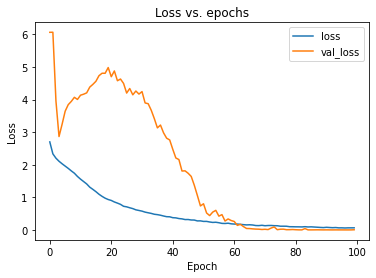

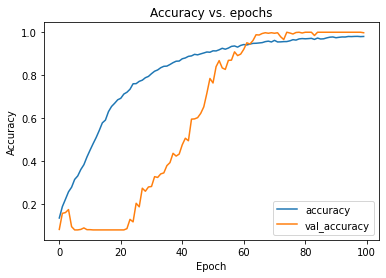

In [ ]:
plot_history(history_cnn_256)

In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_cnn_256_dict = history_cnn_256.history
# Save it under the form of a json file
json.dump(history_cnn_256_dict, open('/content/drive/MyDrive/ncRNA/data/history/history_cnn_256_dict_short.json', 'w'))


In [ ]:
cnn_256.evaluate(X_test_1000e, Y_test_1000e)

27/27 [==============================] - 0s 10ms/step - loss: 0.2346 - accuracy: 0.9394


[0.23464389145374298, 0.939393937587738]

In [ ]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Concatenate, BatchNormalization, GaussianNoise
from tensorflow.keras.layers import LSTM, TimeDistributed, Permute, Reshape, Lambda, RepeatVector, Input, Multiply, SimpleRNN, GRU, LeakyReLU
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
import site
import pandas as pd
import os
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

In [ ]:
rnn_E, history_rnn_E = compile_and_fit_model_basic(model_E_RNN,
                                                  f"rnn_E",
                                                  X_new_train[0].shape,
                                                  X_new_train,
                                                  Y_new_train,
                                                  save_max_epoch=True,
                                                  save_final=True,
                                                  patience_count=20,
                                                  batch_size=128,
                                                  epochs=300,
                                                  class_weight=None,
                                                  validation_data=(X_val_1000e, Y_val_1000e)
                                                   )

Epoch 1/300
61/61 - 588s - loss: 2.3698 - accuracy: 0.1803 - val_loss: 2.7379 - val_accuracy: 0.0793
INFO:tensorflow:Assets written to: rnn_E_model_001_0.079/assets
Epoch 2/300
61/61 - 575s - loss: 2.1509 - accuracy: 0.2446 - val_loss: 2.3303 - val_accuracy: 0.1400
INFO:tensorflow:Assets written to: rnn_E_model_002_0.140/assets
Epoch 3/300
61/61 - 579s - loss: 2.0066 - accuracy: 0.2938 - val_loss: 2.8568 - val_accuracy: 0.1097
Epoch 4/300
61/61 - 576s - loss: 1.9218 - accuracy: 0.3259 - val_loss: 3.2107 - val_accuracy: 0.0992
Epoch 5/300
61/61 - 578s - loss: 1.8420 - accuracy: 0.3491 - val_loss: 2.2237 - val_accuracy: 0.2649
INFO:tensorflow:Assets written to: rnn_E_model_005_0.265/assets
Epoch 6/300
61/61 - 584s - loss: 1.7437 - accuracy: 0.3854 - val_loss: 1.6899 - val_accuracy: 0.3687
INFO:tensorflow:Assets written to: rnn_E_model_006_0.369/assets
Epoch 7/300
61/61 - 583s - loss: 1.6237 - accuracy: 0.4299 - val_loss: 1.4711 - val_accuracy: 0.4609
INFO:tensorflow:Assets written to: rn

In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_rnn_E_dict_2 = history_rnn_E.history
# Save it under the form of a json file
json.dump(history_rnn_E_dict_2, open('/content/drive/MyDrive/ncRNA/data/history/history_rnn_E_dict_r2.json', 'w'))

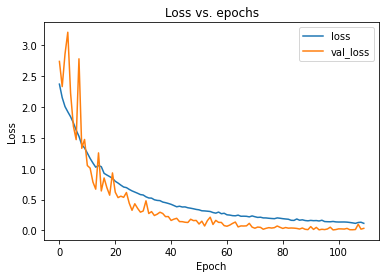

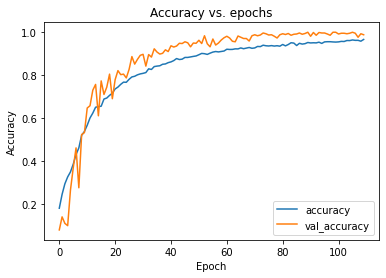

In [23]:
plot_history(history_rnn_E)

In [ ]:


def parallel_model():
  
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same' ,input_shape=inshape))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(2))

    model.add(tf.keras.layers.GaussianNoise(1))
    model.add(tf.keras.layers.Dropout(rate=0.5))

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(4))

    model.add(tf.keras.layers.GaussianNoise(1))
    model.add(tf.keras.layers.Dropout(rate=0.5))

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(2))

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(4))

    model.add(tf.keras.layers.GaussianNoise(1))
    model.add(tf.keras.layers.Dropout(rate=0.5))

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(4))

    model.add(tf.keras.layers.GaussianNoise(1))
    model.add(tf.keras.layers.Dropout(rate=0.5))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))

    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))

    model.add(tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax))
    model._name = model_name
